<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод." data-toc-modified-id="Вывод.-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод.</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

## Подготовка

In [1]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor, Pool
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('/datasets/taxi.csv',parse_dates=[0],index_col = [0])
#display(df.head())
#print(len(df))
data_resample = df.resample('1H').sum()
display(data_resample.head(10))
print(data_resample.info())
print(df.shape)
print(data_resample.shape)
#print(len(data_resample))

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB
None
(26496, 1)
(4416, 1)


In [4]:
#data_resample.index.is_monotonic

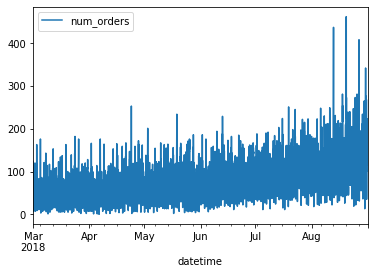

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

In [5]:
data_resample.plot()
plt.show()
display(data_resample['num_orders'].describe())
#display(data_resample.sample(10, random_state = 123))

### Вывод
Ознакомились с полученными данными, пропусков не обнаружено. Типы данных корректны. Провели рессемплирование по часу для дальнейшей работы.

## Анализ

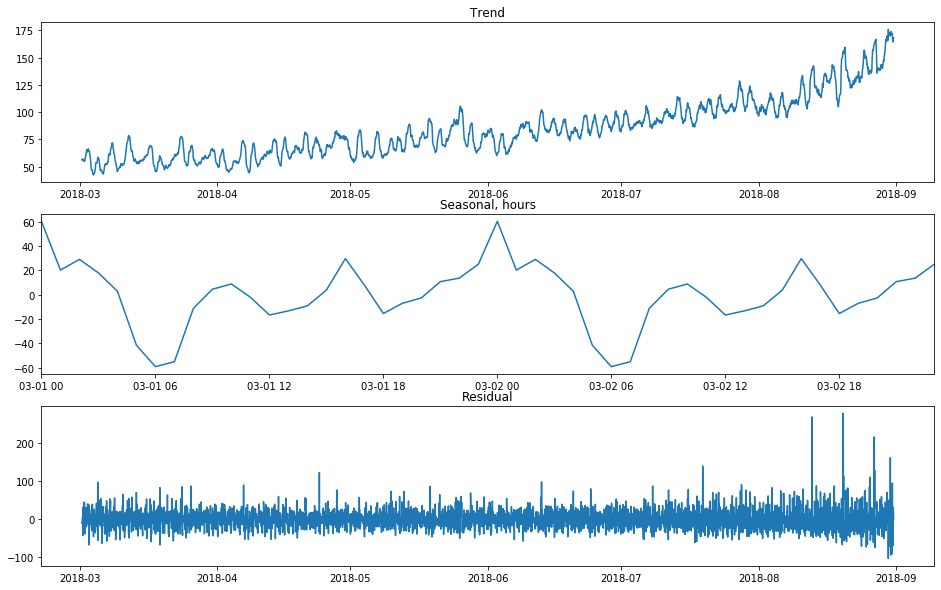

In [6]:
decomposed_data = seasonal_decompose(data_resample)

fig, axs = plt.subplots(3, figsize=(16,10), sharex=False)
axs[0].plot(decomposed_data.trend)
axs[0].set_title("Trend")

axs[1].plot(decomposed_data.seasonal)
axs[1].set_title("Seasonal, hours")
axs[1].set_xlim(('2018-03-01 00:00:00','2018-03-02 23:00:00'))

axs[2].plot(decomposed_data.resid)
axs[2].set_title("Residual")

plt.show()

(4416, 3)

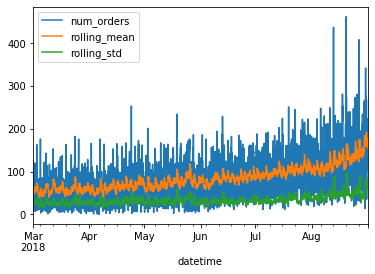

In [7]:
data_resample["rolling_mean"] = data_resample["num_orders"].rolling(20).mean()
data_resample["rolling_std"] = data_resample["num_orders"].rolling(20).std()
data_resample.plot()
data_resample.shape

In [8]:
data_resample = data_resample.drop(['rolling_mean','rolling_std'],axis = 1)

### Вывод.
Можно заметить, что количество заказов начинает расти в начале лета и достигает своего пика в конце августа.

Среднее значение меняется довольно слабо, а стандартное отклонение практически не изменно, ряд можно считать стационарным.

In [9]:
adfuller(data_resample["num_orders"])

(-3.068924289027949,
 0.02894005140261345,
 30,
 4385,
 {'1%': -3.431842162413052,
  '5%': -2.8621993540813637,
  '10%': -2.567120978470452},
 41728.71357827463)

## Обучение

In [10]:
def rmse(first_list, second_list):
    return np.sqrt(mse(first_list, second_list))

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [12]:
make_features(data_resample,24,20)
display(data_resample.head())

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
train, test = train_test_split(data_resample, shuffle=False, test_size=0.1)
train = train.dropna()
features_train = train.drop(['num_orders'],axis = 1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'],axis = 1)
target_test = test['num_orders']
display(data_resample.shape)

(4416, 30)

In [14]:
# предсказание с помощью медианы
pred_median = test['num_orders'].shape[0] * [train['num_orders'].median()]
RMSE_med = rmse(target_test, pred_median)
print("Median(rmse):", RMSE_med)

Median(rmse): 87.15277582981295


In [15]:
RF = RandomForestRegressor(random_state=123)
parametrs = {"max_depth": [1,10],"n_estimators":[100,150,10]}

RF_grid = GridSearchCV(RF,parametrs,cv = TimeSeriesSplit(n_splits=3),verbose=True,n_jobs=-1,scoring= 'neg_mean_squared_error')
RF_grid.fit(features_train,target_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  2.6min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=123,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,

In [16]:
catboost = CatBoostRegressor(loss_function='RMSE',random_state = 123)
parameters_cat = {'depth':[5,10], 'learning_rate':np.arange(0.1,1,0.2)}
catboost_grid = catboost.grid_search(parameters_cat,
            Pool(features_train,target_train),cv=TimeSeriesSplit(n_splits=3),verbose=True)

0:	loss: 33.1527633	best: 33.1527633 (0)	total: 1m 15s	remaining: 11m 17s
1:	loss: 33.5220020	best: 33.1527633 (0)	total: 2m 34s	remaining: 10m 18s
2:	loss: 34.8008783	best: 33.1527633 (0)	total: 3m 47s	remaining: 8m 50s
3:	loss: 35.7167884	best: 33.1527633 (0)	total: 5m 3s	remaining: 7m 35s
4:	loss: 36.7504996	best: 33.1527633 (0)	total: 6m 20s	remaining: 6m 20s
5:	loss: 36.4964527	best: 33.1527633 (0)	total: 13m 7s	remaining: 8m 45s
6:	loss: 36.0542413	best: 33.1527633 (0)	total: 20m 8s	remaining: 8m 37s
7:	loss: 38.7041396	best: 33.1527633 (0)	total: 27m 24s	remaining: 6m 51s
8:	loss: 43.3424068	best: 33.1527633 (0)	total: 33m 42s	remaining: 3m 44s
9:	loss: 44.3445862	best: 33.1527633 (0)	total: 39m 51s	remaining: 0us
Estimating final quality...


In [17]:
final_cat = CatBoostRegressor(depth=catboost_grid["params"]["depth"], 
                              learning_rate=catboost_grid["params"]['learning_rate'],
                              loss_function='RMSE',verbose=100)
final_cat.fit(Pool(features_train,target_train))

0:	learn: 36.9684097	total: 6.06ms	remaining: 6.05s
100:	learn: 21.2410502	total: 3.25s	remaining: 28.9s
200:	learn: 18.2972547	total: 6.62s	remaining: 26.3s
300:	learn: 16.4140357	total: 9.87s	remaining: 22.9s
400:	learn: 14.9079211	total: 13.3s	remaining: 19.9s
500:	learn: 13.5906451	total: 16.8s	remaining: 16.7s
600:	learn: 12.4677805	total: 19.7s	remaining: 13s
700:	learn: 11.4108071	total: 23.3s	remaining: 9.93s
800:	learn: 10.4940732	total: 26.6s	remaining: 6.62s
900:	learn: 9.6595782	total: 30s	remaining: 3.3s
999:	learn: 8.9679636	total: 33.4s	remaining: 0us


In [18]:
lr = LinearRegression()
lr.fit(features_train,target_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Тестирование

In [19]:
%%time
preds_RF_test = RF_grid.best_estimator_.predict(features_test)
RMSE_RF = rmse(target_test,preds_RF_test)
print('RMSE RF:', RMSE_RF)

RMSE RF: 43.89310128393786
CPU times: user 40.4 ms, sys: 782 µs, total: 41.2 ms
Wall time: 105 ms


In [20]:
pred_cat_test = final_cat.predict(features_test)
RMSE_cat = rmse(pred_cat_test,target_test)
print('RMSE cat:', RMSE_cat)

RMSE cat: 40.912636408455285


In [21]:
test_pred = lr.predict(features_test)
RMSE_LR = rmse(target_test,test_pred)
print('RMSE LR:',RMSE_LR )

RMSE LR: 45.17370008663392


### Вывод

Провели исследование по количеству заказов машин на следующий час, использовали стандартные модели, а так же обучение медианой. Наиболее лучшую метрику RMSE показала модель CatBoost'а.

In [22]:
data = [[RMSE_LR],
        [RMSE_cat],
        [RMSE_RF],
        [RMSE_med]]
model = ["LR", "cat", "RF","median"]
pd.DataFrame(data=data, index=model, columns=["RMSE"])

,RMSE
LR,45.173700
cat,40.912636
RF,43.893101
median,87.152776
